## Comparison of PLINK vs. LASSO logistic regression

#### Yosuke Tanigawa (2018/6/13)

Junyang says:

> I just had a list of SNPs ready. There are 149 (including age, sex and 10PCs) in total, which achieves AUC 0.5993. The SNP names and coefficients are attached as a CSV file including their coefficients. Among the variants, the most relevant one is Affx-37072023_T, by which I mean it enters the Lasso model earlier than any others.

#### Method
- There are two data:
    - LASSO: coefficients from Junyang
    - PLINK: summary statistics from PLINK2 run
- Join the two tables and compare the statistics
- Specifically, 
    - Look at the top hits from two methods and see if they are consistent
    - Plot the rank distributions


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib, collections, itertools, os, re, textwrap, logging
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from functools import reduce

from logging.config import dictConfig
from logging import getLogger

dictConfig(dict(
    version = 1,
    formatters = {'f': {'format': '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'}},
    handlers = {
        'h': {'class': 'logging.StreamHandler','formatter': 'f',
              'level': logging.DEBUG}},
    root = {'handlers': ['h'], 'level': logging.DEBUG,},
))

matplotlib.rc('font',**{'size':16, 'family':'sans-serif','sans-serif':['HelveticaNeue', 'Helvetica']})

logger = getLogger('notebook')



In [12]:
repo_dir=os.path.dirname(os.path.dirname(os.path.realpath(os.getcwd())))

private_data_dir=os.path.realpath(
    os.path.join(repo_dir, 'private_data', os.path.basename(os.path.realpath(os.getcwd())))
)

public_data_dir=os.path.realpath(
    os.path.join(repo_dir, 'public_data', os.path.basename(os.path.realpath(os.getcwd())))
)

In [86]:
figs_dir=os.path.realpath(
    os.path.join(repo_dir, 'figs', os.path.basename(os.path.realpath(os.getcwd())))
)

### read the data files

In [29]:
lasso_coeff=pd.read_csv(
    os.path.join(public_data_dir, 'relaxed_coef.HC382.txt'),
    sep=' ', quotechar='"', names=['feature', 'coef'], skiprows=1,
    nrows=None, 
)

In [23]:
gwas_sumstats=pd.read_table(
    os.path.join(public_data_dir, 'ukb16698_v2.HC382.PHENO1.glm.logistic.hybrid.gz'),
    compression='gzip',
    nrows=None, 
)

In [38]:
lasso_coeff['ID'] = lasso_coeff['feature'].map(
    lambda x: re.sub(r'\(|\)|`', '', x).split('_')[0]
)

In [54]:
lasso_coeff['coef_abs'] = lasso_coeff['coef'].abs()

### subset to SNPs (drop covariates)

In [55]:
lasso_coeff_SNPs = lasso_coeff[lasso_coeff['ID'].map(
    lambda x: (x not in ['Intercept', 'age', 'sex']) and (not x[:2] == 'PC')
)]

In [43]:
gwas_sumstats_SNPs = gwas_sumstats[gwas_sumstats['TEST'] == 'ADD']

#### check the overlap of the SNPs from the two datasets

In [56]:
len(set(gwas_sumstats_SNPs['ID']) & set(lasso_coeff_SNPs['ID'])), len(gwas_sumstats_SNPs), len(lasso_coeff_SNPs)

(133, 779830, 137)

In [57]:
set(lasso_coeff_SNPs['ID']) - (set(gwas_sumstats_SNPs['ID']) & set(lasso_coeff_SNPs['ID']))

{'rs28757823', 'rs3093493', 'rs5986877', 'rs850636'}

- These four SNPs are not in the results from PLINK. It is possible that PLINK returned NA for these variants

#### assign ranks

In [64]:
lasso_coeff_SNPs['coef_abs_rank'] = lasso_coeff_SNPs['coef_abs'].rank(ascending=False)

/home/users/ytanigaw/.anaconda3-4.3.1-Linux-x86_64-20170521/envs/dev36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [67]:
lasso_coeff_SNPs.sort_values(by='coef_abs_rank').head(5)

,feature,coef,ID,coef_abs,coef_abs_rank
126,`Affx-80241282_A`,30594.976128,Affx-80241282,30594.976128,1.0
131,`Affx-89025111_G`,3315.762758,Affx-89025111,3315.762758,2.0
127,`Affx-89025225_C`,2473.540401,Affx-89025225,2473.540401,3.0
102,`Affx-80227214_G`,1645.966202,Affx-80227214,1645.966202,4.0
143,`Affx-86889762_A`,14.268651,Affx-86889762,14.268651,5.0


In [68]:
gwas_sumstats_SNPs['P_rank'] = gwas_sumstats_SNPs['P'].rank()

/home/users/ytanigaw/.anaconda3-4.3.1-Linux-x86_64-20170521/envs/dev36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [69]:
gwas_sumstats_SNPs.sort_values(by='P').head(5)

,#CHROM,POS,ID,REF,ALT,FIRTH?,TEST,OBS_CT,OR,SE,T_STAT,P,P_rank
288102,6,32612430,Affx-37072023,T,C,N,ADD,335833,1.173980,0.007518,-21.3369,5.163770e-101,1.0
288110,6,32620775,rs17843619,C,A,N,ADD,335681,1.171748,0.007582,-20.9035,4.976060e-97,2.0
288103,6,32612488,rs9273088,A,C,N,ADD,335829,1.171970,0.007598,-20.8855,7.251760e-97,3.0
288104,6,32613712,rs9273215,G,A,N,ADD,336855,1.171623,0.007588,-20.8751,9.027330e-97,4.0
288112,6,32623430,rs9273339,G,A,N,ADD,336351,1.171459,0.007592,-20.8437,1.739970e-96,5.0


#### join two tables

In [75]:
sumstats = gwas_sumstats_SNPs.merge(
    lasso_coeff_SNPs,
    how='left',
    on='ID'
)

In [76]:
sumstats.head()

,#CHROM,POS,ID,REF,ALT,FIRTH?,TEST,OBS_CT,OR,SE,T_STAT,P,P_rank,feature,coef,coef_abs,coef_abs_rank
0,1,723307,rs28659788,C,G,N,ADD,36598,1.030170,0.053448,-0.556114,0.578133,465085.5,NaN,NaN,NaN,NaN
1,1,727841,rs116587930,G,A,N,ADD,303535,0.984514,0.017587,0.887718,0.374692,314509.0,NaN,NaN,NaN,NaN
2,1,729632,rs116720794,C,T,N,ADD,322090,0.988973,0.020296,0.546508,0.584717,469833.5,NaN,NaN,NaN,NaN
3,1,752721,rs3131972,A,G,N,ADD,335457,1.015182,0.010358,-1.454640,0.145770,137914.0,NaN,NaN,NaN,NaN
4,1,754105,rs12184325,C,T,N,ADD,336834,0.982241,0.019880,0.901528,0.367308,308935.0,NaN,NaN,NaN,NaN


In [77]:
sumstats.shape

(779830, 17)

## visualization

In [79]:
sumstats.sort_values(by='P_rank').head(10)

,#CHROM,POS,ID,REF,ALT,FIRTH?,TEST,OBS_CT,OR,SE,T_STAT,P,P_rank,feature,coef,coef_abs,coef_abs_rank
288089,6,32612430,Affx-37072023,T,C,N,ADD,335833,1.173980,0.007518,-21.3369,5.163770e-101,1.0,`Affx-37072023_T`,-0.043526,0.043526,100.0
288097,6,32620775,rs17843619,C,A,N,ADD,335681,1.171748,0.007582,-20.9035,4.976060e-97,2.0,NaN,NaN,NaN,NaN
288090,6,32612488,rs9273088,A,C,N,ADD,335829,1.171970,0.007598,-20.8855,7.251760e-97,3.0,NaN,NaN,NaN,NaN
288091,6,32613712,rs9273215,G,A,N,ADD,336855,1.171623,0.007588,-20.8751,9.027330e-97,4.0,NaN,NaN,NaN,NaN
288099,6,32623430,rs9273339,G,A,N,ADD,336351,1.171459,0.007592,-20.8437,1.739970e-96,5.0,NaN,NaN,NaN,NaN
288110,6,32627714,rs1063355,T,G,N,ADD,337004,1.171289,0.007587,-20.8388,1.926950e-96,6.0,NaN,NaN,NaN,NaN
288093,6,32615458,rs17612576,G,A,N,ADD,335806,1.171247,0.007596,-20.8090,3.587460e-96,7.0,NaN,NaN,NaN,NaN
288133,6,32634838,rs9274552,A,C,N,ADD,332980,1.171549,0.007618,-20.7841,6.028310e-96,8.0,NaN,NaN,NaN,NaN
288096,6,32620399,rs17843606,G,T,N,ADD,331236,1.170753,0.007621,-20.6857,4.658010e-95,9.0,NaN,NaN,NaN,NaN
288136,6,32635809,rs3828790,T,C,N,ADD,333217,1.170283,0.007661,-20.5250,1.288020e-93,10.0,NaN,NaN,NaN,NaN


In [80]:
sumstats.sort_values(by='coef_abs_rank').head(10)

,#CHROM,POS,ID,REF,ALT,FIRTH?,TEST,OBS_CT,OR,SE,T_STAT,P,P_rank,feature,coef,coef_abs,coef_abs_rank
484031,11,16811332,Affx-80241282,G,A,N,ADD,337025,6.932121,0.712709,-2.71663,0.006595,15572.0,`Affx-80241282_A`,30594.976128,30594.976128,1.0
520532,12,7053285,Affx-89025111,A,G,N,ADD,337010,5.300962,0.766276,-2.17662,0.029509,39391.0,`Affx-89025111_G`,3315.762758,3315.762758,2.0
484318,11,17419233,Affx-89025225,T,C,Y,ADD,337038,59.004012,1.633010,-2.49698,0.012526,22308.0,`Affx-89025225_C`,2473.540401,2473.540401,3.0
250689,5,112179069,Affx-80227214,A,G,N,ADD,336948,8.491631,0.762784,-2.80431,0.005042,13658.0,`Affx-80227214_G`,1645.966202,1645.966202,4.0
733727,19,55665450,Affx-86889762,G,A,Y,ADD,337062,39.646983,1.705630,-2.15757,0.030961,40701.0,`Affx-86889762_A`,14.268651,14.268651,5.0
496237,11,64026185,Affx-80242315,C,T,N,ADD,337109,17.256494,1.166940,-2.44074,0.014657,24615.0,`Affx-80242315_T`,14.157583,14.157583,6.0
465521,10,99220663,Affx-80239797,C,T,N,ADD,337051,22.764887,1.120250,-2.78975,0.005275,13954.0,`Affx-80239797_T`,12.902742,12.902742,7.0
738528,20,6077642,Affx-89020701,CTG,C,N,ADD,336776,8.120442,0.673768,-3.10847,0.001881,8944.0,`Affx-89020701_C`,3.892959,3.892959,8.0
727282,19,45204712,Affx-80261821,G,A,N,ADD,336500,11.415147,0.878156,-2.77279,0.005558,14303.0,`Affx-80261821_A`,3.588788,3.588788,9.0
595992,14,73659429,Affx-86893218,G,A,N,ADD,337032,7.742515,0.762814,-2.68312,0.007294,16383.0,`Affx-86893218_A`,3.579900,3.579900,10.0


In [83]:
sumstats_intersection = sumstats.dropna()

/home/users/ytanigaw/.anaconda3-4.3.1-Linux-x86_64-20170521/envs/dev36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


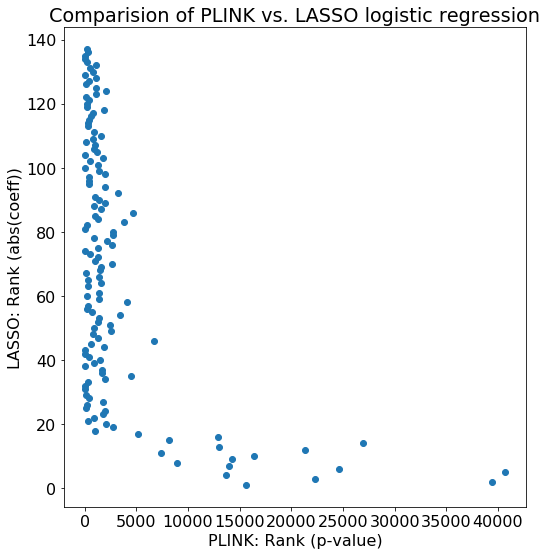

In [95]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 1)
fig_axs = [fig.add_subplot(sp) for sp in gs]
fig_axs[0].scatter(
    sumstats_intersection['P_rank'],
    sumstats_intersection['coef_abs_rank'],
)
fig_axs[0].set_title('Comparision of PLINK vs. LASSO logistic regression')
fig_axs[0].set_xlabel('PLINK: Rank (p-value)')
fig_axs[0].set_ylabel('LASSO: Rank (abs(coeff))')
gs.tight_layout(fig, rect=[0, 0, 1, 1]) 
fig.savefig(
    os.path.join(figs_dir, '20180613_HC382_rank_scatter_pval.png'), 
    bbox_inches="tight", pad_inches=0.0
)

In [90]:
sumstats_intersection['L10OR'] = [np.log10(x) for x in sumstats_intersection['OR']]

/home/users/ytanigaw/.anaconda3-4.3.1-Linux-x86_64-20170521/envs/dev36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [92]:
sumstats_intersection['L10OR_abs'] = sumstats_intersection['L10OR'].abs()

/home/users/ytanigaw/.anaconda3-4.3.1-Linux-x86_64-20170521/envs/dev36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [93]:
sumstats_intersection['L10OR_abs_rank'] = sumstats_intersection['L10OR_abs'].rank(ascending=False)


/home/users/ytanigaw/.anaconda3-4.3.1-Linux-x86_64-20170521/envs/dev36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/home/users/ytanigaw/.anaconda3-4.3.1-Linux-x86_64-20170521/envs/dev36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


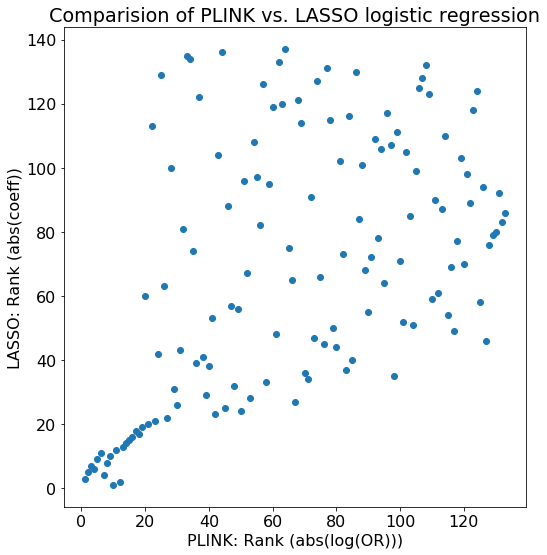

In [94]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 1)
fig_axs = [fig.add_subplot(sp) for sp in gs]
fig_axs[0].scatter(
    sumstats_intersection['L10OR_abs_rank'],
    sumstats_intersection['coef_abs_rank'],
)
fig_axs[0].set_title('Comparision of PLINK vs. LASSO logistic regression')
fig_axs[0].set_xlabel('PLINK: Rank (abs(log(OR)))')
fig_axs[0].set_ylabel('LASSO: Rank (abs(coeff))')
gs.tight_layout(fig, rect=[0, 0, 1, 1]) 
fig.savefig(
    os.path.join(figs_dir, '20180613_HC382_rank_scatter_OR.png'), 
    bbox_inches="tight", pad_inches=0.0
)

In [88]:
len(gwas_sumstats_SNPs), len(lasso_coeff_SNPs)

(779830, 137)